<a href="https://colab.research.google.com/github/ravishankarramakrishnan/Deep_Learning_Practice/blob/master/Sentiment_Analysis_with_BERT_and_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Outline:**
## **Sentiment Analysis with Deep Learning using BERT**

### What is BERT

BERT is a large-scale transformer-based Language Model that can be finetuned for a variety of tasks.

For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805). 

[HuggingFace documentation](https://huggingface.co/transformers/model_doc/bert.html)

[Bert documentation](https://characters.fandom.com/wiki/Bert_(Sesame_Street) ;)

### Dataset to be Used

We will use the SMILE Twitter dataset.

_Wang, Bo; Tsakalidis, Adam; Liakata, Maria; Zubiaga, Arkaitz; Procter, Rob; Jensen, Eric (2016): SMILE Twitter Emotion dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.3187909.v2_


In [1]:
# Importing the Libraries

import torch
import pandas as pd
from tqdm.notebook import tqdm # Essentially tracks how far your For Loops are gone - Useful in Training
import matplotlib.pyplot as plt

In [2]:
# Loading and Exploring the Data

# Mounting the Collab Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading the CSV

data = pd.read_csv('/content/drive/My Drive/Projects/Sentiment Analysis with BERT - Pytorch/smile-annotations-final.csv', 
                   names = ["id", "text", "category"], error_bad_lines=False)

# Set the ID as Index
data.set_index('id', inplace= True)

In [4]:
# Display the Head and Tail of the Datasets

display(data.head(), data.tail())

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


,text,category
id,,
613678555935973376,MT @AliHaggett: Looking forward to our public ...,happy
613294681225621504,@britishmuseum Upper arm guard?,nocode
615246897670922240,@MrStuchbery @britishmuseum Mesmerising.,happy
613016084371914753,@NationalGallery The 2nd GENOCIDE against #Bia...,not-relevant
611566876762640384,@britishmuseum Experience #battlewaterloo from...,nocode


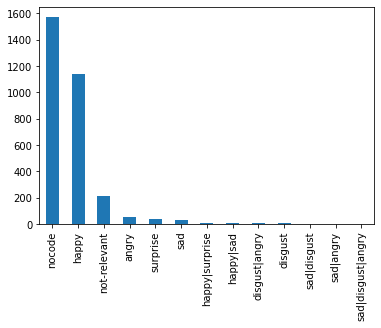

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [5]:
# 1. Exploratory Data Analysis

# Check the Unique Instances of Category Column

data.category.value_counts().plot(kind= "bar")
plt.show();

data.category.value_counts()

In [6]:
# Remove Multiple and No Code Category as BERT can predict one output

# Remove Pipe(|) contains in the Dataframe

df = data[ ~data['category'].str.contains('\|') ] # We use \ as | is a Special Symbol. ~ is for Not in
print(len(df), len(data))

3053 3085


In [7]:
# Remove Nocode
df = df[ df.category != 'nocode' ]

# Show the Value Counts
df.category.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: category, dtype: int64

In [8]:
# Class Imbalance is Present
# Build a Dictionary to convert the Emotion to Relevant Numbers

# Get the Label of Category
cat_label = df.category.unique()

# Create a Dictionary

label_dict = {}
for num, label in enumerate(cat_label):
    label_dict[label] = num

# Printing to Validate the Dictionary
print(label_dict)

{'happy': 0, 'not-relevant': 1, 'angry': 2, 'disgust': 3, 'sad': 4, 'surprise': 5}


In [9]:
# Create a DataFrame Column that replaces category to Mapped Values

df['label'] = df.category.replace(label_dict)

# Validate by seeing Last 5 Observation
df.tail()

,text,category,label
id,,,
611258135270060033,@_TheWhitechapel @Campaignforwool @SlowTextile...,not-relevant,1
612214539468279808,“@britishmuseum: Thanks for ranking us #1 in @...,happy,0
613678555935973376,MT @AliHaggett: Looking forward to our public ...,happy,0
615246897670922240,@MrStuchbery @britishmuseum Mesmerising.,happy,0
613016084371914753,@NationalGallery The 2nd GENOCIDE against #Bia...,not-relevant,1


In [10]:
# 2. Training and Validation Split

# Common Train Test Split without distribution parameters will not work as it has a Class Imbalance.
# So We split each class based on Training/Validation Split - Stratified Splitting Approach

# Import traintestsplit

from sklearn.model_selection import train_test_split

# Split the Data

X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.label.values,   # Here You need to pass Index for 'id'
                                                  test_size= 0.15, random_state= 42,
                                                  stratify= df.label.values)

In [11]:
# Create a Column Datatype, which is Initially Not Set

df['data_type'] = ['not_set'] * df.shape[0]  # Set for all Samples - Length

df.head()

,text,category,label,data_type
id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,not_set
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,not_set
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,not_set
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,not_set
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,not_set


In [12]:
# If ID is present in training set, make data type as training set and vice versa

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

# Use Groupby to see the Distribution across all classes

df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

In [13]:
# 3. Load Tokenizer and Encode the Data
 
# Use Tokeniser to Tokenize Textual words into Numerical representation. It takes Raw text and Splits into Token

# Install Transformers
!pip install transformers

In [14]:
# Importing Tokeniser 
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [15]:
# We Use Pretrained BERT Tokeniser to tokenise our words

# We Use Uncased (lowercase) pretrained model. So we ned to lowercase our imputs. So we pass True to do lower case
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case= True)

In [16]:
# Convert our Sentence/Tweets from language (data) into encoded form. So we use Batch Encode Plus

# Training Data
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == 'train'].text.values,
    add_special_tokens= True, # EOS, SOS etc (End/Start of Sentence)
    return_attention_mask= True, # Tells us Where the Real values are in a sparse vector [As we fix a max size and fill it with 0's]
    pad_to_max_length= True,
    max_length= 256,
    return_tensors= 'pt' # For Pytorch
)


# Validation Data
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'val'].text.values,
    add_special_tokens= True, # EOS, SOS etc (End/Start of Sentence)
    return_attention_mask= True, # Tells us Where the Real values are in a sparse vector [As we fix a max size and fill it with 0's]
    pad_to_max_length= True,
    max_length= 256,
    return_tensors= 'pt' # For Pytorch
)

# The Encoded Data Vals Above returns a Dictionary. We use it below to train BERT Model. eg: encoded_data_train['input_ids', 'attention_masks'] etc

# Splitting your dataset to train for BERT
# Training Data
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == "train"].label.values)

# Validation Data
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == "val"].label.values)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [17]:
# We Gor Our Encoded Dataset from before. We need to create Training and Validation dataset

# We Commonly use TensorDataset to make a Dataset in Pytorch

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [18]:
# Print the Length of Training and Test Dataset
print("The Length of Training data is {} and the Test data is {}".format(len(dataset_train), len(dataset_val)) ) # 85% Train, 15% Test

The Length of Training data is 1258 and the Test data is 223


In [19]:
# 5. Setting up the BERT Pretrained Model - There Might be a confusion with BART vs BERT

# Import Pretrainied Model
from transformers import BertForSequenceClassification # 1 Sequence is Classified into 1 of 6 Classes

In [20]:
# Fine Tuning the Architecture

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels = len(label_dict), # 6
                                                      output_attentions= False,
                                                      output_hidden_states= False
                                                      )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
# 6. Create Data Loaders

# It helps in Iterating the Model through the Datasets in Batches

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Creating HyperParameters
batch_size= 32

# Creating DataLoaders for Train and Validation
dataloader_train = DataLoader(dataset_train,
                              sampler= RandomSampler(dataset_train), # Prevents model from learning Sequence based differences
                              batch_size= batch_size 
                              )

dataloader_val = DataLoader(dataset_val,
                              sampler= RandomSampler(dataset_val), # Prevents model from learning Sequence based differences
                              batch_size= batch_size 
                              )

In [23]:
# 7. Setting up Optimizer and Scheduler

# Optimizer helps in Defining our Learning Rate for Each Epoch

from transformers import AdamW, get_linear_schedule_with_warmup  # AdamW - Adam Weight Decay

In [26]:
# Instantiate

optimizer = AdamW(model.parameters(), # AdamW is Stochaistic Optimization Approach
                  lr=1e-5 ,# default is from 2e-5 to 5e-5 for LR. It changes project to project and is trial and error method. Depends on Dataset
                  eps= 1e-8) # Epsilon Value

In [27]:
# Scheduler - This Controls the Learning Rate

epochs= 10

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps= 0,
    num_training_steps= len(dataloader_train) * epochs # How many times we want our LR to change
)

In [29]:
# 8. Defining our Performance Metrics

import numpy as np
from sklearn.metrics import f1_score

# Define F1 score Function to Get the Maximum Output Values from the Obtained predict probs. Eg: [0.9, 0.05, 0.04, 0.01, 0, 0] => argmax gives index 0

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis= 1).flatten() # As we dont want List of Lists. We want a Single Iterable(array/list)
    labels_flat = labels.flatten() # As it might come as List of List
    return f1_score(labels_flat, preds_flat, average= "weighted") # Weighted Average as the dataset has a class distribution problem (Class Imbalance): We can use 'macro'
    # F1 Score is Primarily used when Class Imbalance is Present

# Define a Function to print out Accuracy per class

def accuracy_per_class(preds, labels):
    # Create Inverse Dict 
    label_dict_inverse = {v: k for k, v in label_dict.items()} # Note: A Dictionary Should have "V:K" and not "V, k"
    # Flatten and Get the Correct Predictions
    preds_flat = np.argmax(preds, axis= 1).flatten() # As we dont want List of Lists. We want a Single Iterable(array/list)
    labels_flat = labels.flatten() # As it might come as List of List

    # Iterate over Labels and Update the Dictionary Count
    for label in np.unique(labels_flat):
        # Use Numpy Indexing and get the True Valued Datasets
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: { label_dict_inverse[label] }')
        #print(f'The Accuracy: { len(y_preds[y_preds == label]) / len(y_true) } ')
        print(f'The Accuracy: { len(y_preds[y_preds == label]) } / { len(y_true) } \n')

In [34]:
# 9. Creating our Training Loop - Based off and Adapted from HuggingFace run_glue.py

# Seeding Consistantly is a Must in Pytorch
seed_val = 17
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [35]:
# Check the Device  
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)
# We Must Send our Model to the Device that we use
model.to(device)

cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [47]:
# Define a Function for Evaluating DataLoader

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():    # We Disable the Gradients     
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy() # If you are using GPU, You need to pullback values to CPU for Numpy Calculations
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [39]:
# Training our Model

for epoch in tqdm(range(1, epochs+1 )):

    # Start the Training of the Model - Model is in Training Mode
    model.train()
    # Set Training Loss - We add Each Batch's loss here
    loss_train_total = 0

    # Progress bar in TQDM to see the Batches training
    progress_bar = tqdm( dataloader_train, desc= "Epoch {:1d}".format(epoch),
                        leave= False, # Lets it Overwrite itself for each new Epoch
                        disable= False)
    
    # For Each Epoch we use Batches - To do Backpropagation
    for batch in progress_bar:

        # Set our Gradients to Zero
        model.zero_grad()

        # Our DataLoader has 3 Variables - Tuple of 3 items. Lets break them
        batch = tuple(b.to(device) for b in batch) # We Want to ensure Each individual items on the Tuple are in Correct device

        # Pull out Inputs - BERT Model Accepts 3 types
        inputs = {
            'input_ids' : batch[0], # First Item of the Tuple
            'attention_mask' : batch[1],
            'labels' : batch[2]
        }

        # Get the Outputs
        outputs = model( **inputs ) # Unpacks the input Dictionary well

        # BERT Model returns Loss/Logits. It is a Dictionary
        loss= outputs[0]

        # Add the Loss at each batches
        loss_train_total += loss.item()
        
        # We Backpropagate
        loss.backward()

        # Clip Our Gradient. Takes the Gradient and returns a Norm. Helps Gradients not slip out and become Small/Big - Helps Generalisation
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # All Weights will be of Norm 1

        # Step our Optimizer and Scheduler
        optimizer.step()
        scheduler.step()

        # Update Progress Bar to Show the Loss
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch) )})

    
    # Inside the Epoch Loop we Save the Model

    torch.save(model.state_dict(), f'BERT_ft_epoch{epoch}.model') # State Dict has All weights of the model in all the layers

    # Report some values
    tqdm.write(f'\nEpoch: {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    # Write Average Training Loss per Epoch
    tqdm.write(f'Training Loss: {loss_train_avg}')

    # Use Evaluate Function to get the Validation Loss - To Know if Model is Overtraining
    # Overtraining: When Your Loss Goes down and your Validation Loss goes up. # It Starts to Perfectly Replicate Training Data/OverFitting; No Generalisation

    val_loss, predictions, true_vals = evaluate(dataloader_val)  # We Dont Change any Gradients and Care about Loss and Logits(pred). Its similar to Training Function, No Backprob
    val_f1 = f1_score_func(predictions, true_vals)
    # Print Validation Loss
    tqdm.write(f'Validation Loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')



Epoch: 1
Training Loss: 1.2354127138853073
Validation Loss: 0.8234545077596392
F1 Score (Weighted): 0.6656119824269878



Epoch: 2
Training Loss: 0.7505358815193176
Validation Loss: 0.6840845772198269
F1 Score (Weighted): 0.6690079619291663



Epoch: 3
Training Loss: 0.6107763655483722
Validation Loss: 0.5695103577205113
F1 Score (Weighted): 0.7494680044747108



Epoch: 4
Training Loss: 0.5075998283922672
Validation Loss: 0.5241754991667611
F1 Score (Weighted): 0.7959778979958352



Epoch: 5
Training Loss: 0.44232408218085767
Validation Loss: 0.5288688540458679
F1 Score (Weighted): 0.7948034786408714



Epoch: 6
Training Loss: 0.4058733332902193
Validation Loss: 0.5026696409497943
F1 Score (Weighted): 0.8147319924032463



Epoch: 7
Training Loss: 0.3554230896756053
Validation Loss: 0.4978496645178114
F1 Score (Weighted): 0.8028679283524612



Epoch: 8
Training Loss: 0.34721786603331567
Validation Loss: 0.49749040603637695
F1 Score (Weighted): 0.8089502127170288



Epoch: 9
Training Loss: 0.31495661875233055
Validation Loss: 0.5057859740086964
F1 Score (Weighted): 0.8076899852031336



Epoch: 10
Training Loss: 0.30837446032091975
Validation Loss: 0.4988169159208025
F1 Score (Weighted): 0.8089502127170288



In [40]:
# Evaluation of the Models

_, predictions, true_vals = evaluate(dataloader_val)

In [41]:
# Get Accuracy Per Class

accuracy_per_class(predictions, true_vals)

Class: happy
The Accuracy: 165 / 171 

Class: not-relevant
The Accuracy: 23 / 32 

Class: angry
The Accuracy: 0 / 9 

Class: disgust
The Accuracy: 0 / 1 

Class: sad
The Accuracy: 0 / 5 

Class: surprise
The Accuracy: 0 / 5 



We Need to Train our Model to More Epochs to get the Desired Performance. For training 10 Epochs, the model was pretty good. 17 mins for 10 Epochs in GPU

In [42]:
# Download from Colab

from google.colab import files
files.download("/content/BERT_ft_epoch9.model")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# If you want to Load the Models after Sometime. Follow the Procedure

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)
pass

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [50]:
model.load_state_dict(torch.load('/content/BERT_ft_epoch3.model', map_location=torch.device('cpu')))
# We Map the Model GPU trained to CPU by map_location so that there is no discrepency and the keys are matched sucessfully

<All keys matched successfully>

In [51]:
# Get the Evaluations from data on 3rd Epoch

_, predictions, true_vals = evaluate(dataloader_val)

In [52]:
accuracy_per_class(predictions, true_vals)
# This was the Accuracy on 3rd Epoch

Class: happy
The Accuracy: 167 / 171 

Class: not-relevant
The Accuracy: 11 / 32 

Class: angry
The Accuracy: 0 / 9 

Class: disgust
The Accuracy: 0 / 1 

Class: sad
The Accuracy: 0 / 5 

Class: surprise
The Accuracy: 0 / 5 

